In [116]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [117]:
InputFiles = {'Expenditures':('1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E','Food Expenditures (2015-16)'),
              'Prices':('1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E','Food Prices (2015-16)'),
              'HH Characteristics':('1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E','Household Characteristics'),
              'FCT':('1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E','FCT'),
              'RDI':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','RDI'),}

In [118]:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd

def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
x = get_clean_sheet(InputFiles['Expenditures'][0],
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in x.columns:
    x['m'] = 1

## important to keep the type of household id value as str.
x['i'] = x['i'].astype(str)

x = x.set_index(['i','t','m', 'j'])


# x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x = x.replace(0,np.nan)

# Get HH characteristics...
z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in z.columns:
    z['m'] = 1

z = z.set_index(['i','t','m'])
z.columns.name = 'k'

z = z.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Get prices
p = get_clean_sheet(InputFiles['Prices'][0],
                    sheet=InputFiles['Prices'][1])

if 'm' not in p.columns:  # Supply "market" indicator if missing
    p['m'] = 1

p = p[p['u'] == 'Kg']
p = p.drop(columns = ['u'])
p = p.set_index(['t','m', 'j'])

p = p.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

#### This bit peculiar to Niger FCT #####
#fct = fct.loc[fct.Code.str.len()==6]
#fct = fct.set_index('Code')
#fct.columns = [v.replace('\n',' ') for v in fct.columns]
########################################
fct = fct.rename(columns={'index':'j'})
fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

################## RDI, if available (consider using US) #####################
rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

In [119]:
import cfe
result = cfe.Regression(y=np.log(x['Expenditure']),d=z)
result.get_beta().sort_values(ascending=False) # Check sanity...

j
Orange                1.047139
Banana                0.886952
Butter/ghee           0.825541
Berbere               0.814190
Oils                  0.796363
Barley                0.743966
Bread/biscuit         0.730363
Field Pea             0.725542
Goat & mutton meat    0.713874
Beef                  0.681723
Onion                 0.670982
Sorghum               0.660504
Kariya                0.654965
Tomato                0.648224
Horsebeans            0.622453
Leafy Greens          0.620159
Teff                  0.615684
Soda                  0.605817
Sugar                 0.596649
Eggs                  0.588911
Injera                0.573011
Lentils               0.546167
Coffee                0.545892
Tea                   0.539507
Wheat                 0.532949
Potato                0.510617
Chick Pea             0.505407
Maize                 0.499763
Chat/Kat              0.489810
Milk                  0.486525
Pasta/Macaroni        0.457429
Salt                  0.445803
Harico

In [120]:
result.to_pickle('./foo.pickle')

In [121]:
import cfe
result = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...
xhat = result.predicted_expenditures()
# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/p['Price'].unstack('j')).dropna(how='all')
# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

In [122]:
use = fct.index.intersection(qhat.columns)
nutrients = qhat[use]@fct.loc[use,:]
nutrients.mean() 

n
Energy          120718.016816
Protein           2176.301195
Vitamin A        22091.854506
Vitamin D          100.206961
Vitamin E          145.547144
Vitamin C         1612.369789
Vitamin B-6         62.686755
Vitamin B-12       129.949153
Calcium          27744.443035
Magnesium        16586.057306
Iron               716.127654
Zinc               384.809030
Fiber              384.159024
Folate             572.910923
Carbohydrate      3405.422480
Niacin             171.645342
Phosphorus       19669.290384
Potassium        21085.086611
Riboflavin          13.059875
Thiamin             19.347440
Vitamin K          105.990689
dtype: float64

In [123]:
z.columns = [
    col.replace('Females', 'F')
       .replace('Males', 'M')
       .replace('51-99', '51+')
    for col in z.columns
]

In [124]:
z = z[rdi.columns.tolist()]
hh_rdi = z@rdi.T
hh_rwi = hh_rdi*7

In [125]:
# Match up nutrient names
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)
#nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()
nutrient_ratio = (nutrients[use_nutrients] / hh_rwi[use_nutrients].where(hh_rwi[use_nutrients] != 0)).dropna()


In [126]:
#%matplotlib inline

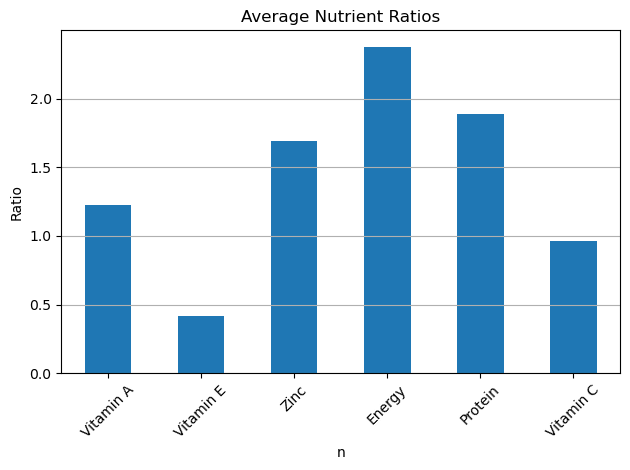

In [127]:
import matplotlib.pyplot as plt
selected_nutrients = ['Vitamin A', 'Vitamin E', 'Zinc', 'Energy', 'Protein', 'Vitamin C']
nutrient_means = nutrient_ratio[selected_nutrients].mean()
nutrient_means.plot(kind='bar')
plt.title('Average Nutrient Ratios')
plt.ylabel('Ratio')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()